# A Toy Implementation of CBOW

Adapted from _Efficient estimation of word representations in vector space_ by Mikolov et al., 2013.

Author: Pierre Nugues

The imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import os
import regex as re
from collections import Counter
import collections
from math import log
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split


## Parameters

The embedding size and context size

In [2]:
#embedding_dim = 50
w_size = 2
c_size = w_size * 2 + 1

## The Corpus

In [3]:
corpus = 'homer'  # 'homer' dickens' 'selma' 'big'
colab = False  # On my machine or on colab
debug = False

In [17]:
if colab:
    BASE_PATH = '/content/drive/My Drive/Colab Notebooks/'
else:
    BASE_PATH = '/Users/pierre/Documents/Cours/EDAN20/corpus/'

In [18]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

We read the files from a folder

In [19]:
def get_files(dir, suffix):
    """
    Returns all the files in a folder ending with suffix
    :param dir:
    :param suffix:
    :return: the list of file names
    """
    files = []
    for file in os.listdir(dir):
        if file.endswith(suffix):
            files.append(file)
    return files


def load_corpus(path):
    files = get_files(path, 'txt')
    files = [path + file for file in files]
    print(files)
    text = ''
    for file in files:
        text += open(file).read()
    return text

In [20]:
if corpus == 'homer':
    # text = 'Sing, O goddess, the anger of Achilles son of Peleus'.lower()
    text1 = open(BASE_PATH + 'Homer/iliad.txt',
                 encoding='utf-8').read().lower()
    text2 = open(BASE_PATH + 'Homer/odyssey.txt',
                 encoding='utf-8').read().lower()
    text = text1 + text2
    test_words = ['he', 'she', 'ulysses', 'penelope', 'achaeans', 'trojans',
                  'achilles', 'sea', 'helen', 'ship', 'her', 'fight']
if corpus == 'dickens':
    path = BASE_PATH + 'Dickens/'
    text = load_corpus(path)
    test_words = ['he', 'she', 'paris', 'london', 'table', 'rare', 'monday', 
                  'sunday', 'man', 'woman', 'king', 'queen', 'boy',
                  'girl']
elif corpus == 'selma':
    path = BASE_PATH + 'Selma/'
    text = load_corpus(path)
    test_words = ['han', 'hon', 'att', 'bord', 'bordet', 'måndag', 'söndag', 
                  'man', 'kvinna', 'kung', 'drottning',
                  'pojke', 'flicka']
elif corpus == 'big':
    path = BASE_PATH + 'Dickens/'
    text = load_corpus(path)
    path = BASE_PATH + 'Norvig/'
    text += load_corpus(path)
    test_words = ['he', 'she', 'paris', 'london', 'table', 'rare', 'monday', 
                  'sunday', 'man', 'woman', 'king', 'queen', 'boy',
                  'girl']

## Processing the Corpus

We set all the text in lowercase

In [21]:
text = text.lower()
words = re.findall('\p{L}+', text)
words[:5]

['book', 'i', 'sing', 'o', 'goddess']

In [22]:
vocab = sorted(list(set(words)))
vocab[:10]

['a',
 'abantes',
 'abarbarea',
 'abas',
 'abate',
 'abated',
 'abetting',
 'abhorred',
 'abians',
 'abide']

In [23]:
vocab_size = len(vocab)
vocab_size

9768

In [24]:
idx2word = dict(enumerate(vocab))
word2idx = {v: k for k, v in idx2word.items()}
# word2idx

In [25]:
words_idx = [word2idx[word] for word in words]

In [26]:
def create_Xy(words):
    (X, y) = ([], [])
    c_size = 2 * w_size + 1
    for i in range(len(words) - c_size + 1):
        X.append(words[i: i + w_size] +
                       words[i + w_size + 1: i + c_size])
        y.append(words[i + w_size])
    return X, y

In [27]:
X, y = create_Xy(words)

In [28]:
X[2:5]

[['sing', 'o', 'the', 'anger'],
 ['o', 'goddess', 'anger', 'of'],
 ['goddess', 'the', 'of', 'achilles']]

In [29]:
y[2:5]

['goddess', 'the', 'anger']

In [30]:
X, y = create_Xy(words_idx)

In [31]:
X = torch.LongTensor(X)
X.size()

torch.Size([271502, 4])

In [32]:
X[2:5]

tensor([[7663, 5691, 8548,  358],
        [5691, 3697,  358, 5735],
        [3697, 8548, 5735,   67]])

In [33]:
y = torch.LongTensor(y)

In [34]:
y[2:5]

tensor([3697, 8548,  358])

## Embeddings

In [35]:
embedding_dim = 5

In [36]:
embedding = nn.Embedding(vocab_size, embedding_dim)
embedding

Embedding(9768, 5)

In [37]:
embedding.state_dict()

OrderedDict([('weight',
              tensor([[-0.2197, -0.2524, -0.0096, -0.6269,  0.9489],
                      [-0.4396, -0.2060, -0.4804,  0.8526,  0.4017],
                      [ 0.7069,  0.9471, -1.4317,  1.1851, -1.1871],
                      ...,
                      [ 0.0973, -0.4191,  0.4433,  1.4194,  0.6204],
                      [ 0.2059, -0.7927, -0.4884, -0.1608, -0.1177],
                      [-2.0196, -0.9487,  0.5686,  0.0996, -1.1322]]))])

In [38]:
embedding.weight[:5]

tensor([[-0.2197, -0.2524, -0.0096, -0.6269,  0.9489],
        [-0.4396, -0.2060, -0.4804,  0.8526,  0.4017],
        [ 0.7069,  0.9471, -1.4317,  1.1851, -1.1871],
        [ 1.6712,  2.5037, -0.4875,  0.1586, -0.6008],
        [-2.4211, -0.2598, -0.2616, -1.4016, -0.3101]],
       grad_fn=<SliceBackward0>)

In [39]:
embedding(torch.LongTensor([3, 2, 1]))

tensor([[ 1.6712,  2.5037, -0.4875,  0.1586, -0.6008],
        [ 0.7069,  0.9471, -1.4317,  1.1851, -1.1871],
        [-0.4396, -0.2060, -0.4804,  0.8526,  0.4017]],
       grad_fn=<EmbeddingBackward0>)

In [40]:
embedding(X[2:5])

tensor([[[ 0.4633,  0.4616, -0.2462,  0.6131,  0.8388],
         [-0.9238, -0.1900, -0.3940, -0.2841, -2.0084],
         [-0.7078,  0.1404, -0.1050, -0.7115,  1.3475],
         [ 1.1688,  0.4074,  1.4692,  1.5402, -0.2261]],

        [[-0.9238, -0.1900, -0.3940, -0.2841, -2.0084],
         [ 0.6921,  1.0906, -1.3340,  1.8316, -1.5643],
         [ 1.1688,  0.4074,  1.4692,  1.5402, -0.2261],
         [-0.2756, -1.3336,  0.2185, -0.8684,  1.4908]],

        [[ 0.6921,  1.0906, -1.3340,  1.8316, -1.5643],
         [-0.7078,  0.1404, -0.1050, -0.7115,  1.3475],
         [-0.2756, -1.3336,  0.2185, -0.8684,  1.4908],
         [-0.7077,  0.7486, -1.2832, -0.0102,  1.3289]]],
       grad_fn=<EmbeddingBackward0>)

In [41]:
embedding(X[2:5]).size()

torch.Size([3, 4, 5])

In [42]:
embedding(X[2:5]).mean(dim=1)

tensor([[ 1.4195e-04,  2.0484e-01,  1.8100e-01,  2.8941e-01, -1.2054e-02],
        [ 1.6540e-01, -6.4217e-03, -1.0069e-02,  5.5484e-01, -5.7701e-01],
        [-2.4975e-01,  1.6150e-01, -6.2593e-01,  6.0364e-02,  6.5072e-01]],
       grad_fn=<MeanBackward1>)

## Embedding Bags

In [43]:
embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)

In [44]:
embedding_bag = nn.EmbeddingBag.from_pretrained(
    embedding.state_dict()['weight'])

In [45]:
embedding_bag(X[2:5])


tensor([[ 1.4195e-04,  2.0484e-01,  1.8100e-01,  2.8941e-01, -1.2054e-02],
        [ 1.6540e-01, -6.4217e-03, -1.0069e-02,  5.5484e-01, -5.7701e-01],
        [-2.4975e-01,  1.6150e-01, -6.2593e-01,  6.0364e-02,  6.5072e-01]])

## Cosine similarity

In [46]:
def most_sim_vecs(u, E, N=10):
    cos = nn.CosineSimilarity()
    cos_sim = cos(u.unsqueeze(dim=0), E)
    sorted_vectors = sorted(range(len(cos_sim)),
                            key=lambda k: -cos_sim[k])
    return sorted_vectors[1:N + 1]

In [47]:
most_sim_vecs(embedding_bag.weight[0], embedding_bag.weight)

[6160, 6333, 4156, 9394, 269, 5225, 8276, 6434, 8622, 8805]

In [48]:
def sim_test_words(test_words, word2idx, model, N=10):
    most_sim_words = {}
    with torch.no_grad():
        E = model[0].weight
        for w in test_words:
            most_sim_words[w] = most_sim_vecs(E[word2idx[w]], E, N)
            most_sim_words[w] = list(map(idx2word.get, most_sim_words[w]))
            print(w, most_sim_words[w])

## The Architecture

In [49]:
embedding_dim = 50

In [50]:
model = nn.Sequential(
    nn.EmbeddingBag(vocab_size, embedding_dim),
    nn.Linear(embedding_dim, vocab_size))
model

Sequential(
  (0): EmbeddingBag(9768, 50, mode='mean')
  (1): Linear(in_features=50, out_features=9768, bias=True)
)

In [51]:
model(X[2:7])

tensor([[ 0.0333, -0.1703, -0.2281,  ...,  0.0295,  0.3106,  0.1363],
        [-0.2216, -0.1459, -0.4870,  ...,  0.2909,  0.3207, -0.3923],
        [-0.0215,  0.4377,  0.0982,  ...,  0.0033,  0.0923,  0.1690],
        [ 0.1256, -0.0816,  0.1194,  ...,  0.1172,  0.0826,  0.1682],
        [-0.2369, -0.4697, -0.3122,  ...,  0.2402,  0.4668, -0.1937]],
       grad_fn=<AddmmBackward0>)

In [52]:
"""class ModelCBOW(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embs.state_dict()['weight'])
        self.fc = nn.Linear(embedding_dim, vocab_size)

    def forward(self, X):
        X = self.embedding(X)
        X = X.mean(dim=1)
        return self.fc(X)"""

"class ModelCBOW(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.embedding = nn.Embedding.from_pretrained(embs.state_dict()['weight'])\n        self.fc = nn.Linear(embedding_dim, vocab_size)\n\n    def forward(self, X):\n        X = self.embedding(X)\n        X = X.mean(dim=1)\n        return self.fc(X)"

In [53]:
# model = ModelCBOW()

In [54]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0855, -0.8331, -1.2195,  ...,  1.0000, -1.0432, -0.5915],
                      [-0.4350, -1.6720,  0.0238,  ...,  1.8459, -1.0771, -0.6815],
                      [-1.5126,  2.7201, -1.1328,  ...,  0.2764,  2.2296,  1.9437],
                      ...,
                      [-0.5555,  1.1247,  0.6710,  ..., -0.4662, -0.0126, -1.3139],
                      [ 2.1909,  0.8829,  0.5889,  ..., -0.4768, -0.6070,  0.9005],
                      [ 0.2502,  1.9061,  1.2361,  ...,  0.0352,  0.5654,  0.9707]])),
             ('1.weight',
              tensor([[-0.0821,  0.1169,  0.0793,  ...,  0.0020, -0.0126,  0.0317],
                      [ 0.0202,  0.0407, -0.0577,  ...,  0.0036, -0.0222,  0.0970],
                      [ 0.0871,  0.0561,  0.0947,  ...,  0.1172,  0.0361, -0.0720],
                      ...,
                      [ 0.1151, -0.0881,  0.0428,  ...,  0.0082,  0.0687, -0.0011],
                      [ 0.0824, -0.1305, -0.0797,  

In [55]:
loss_fn = nn.CrossEntropyLoss()    # cross entropy loss
optimizer = torch.optim.NAdam(model.parameters(), lr=0.025)

In [56]:
BATCH_SIZE = 1024

In [57]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1)

In [58]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [59]:
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training the Model

Train validation loop to be able to call it

In [60]:
def train_val_loop():
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    model.train()
    for epoch in tqdm(range(10)):
        train_loss = 0
        train_acc = 0
        batch_cnt = 0
        for X_batch, y_batch in train_dataloader:
            y_batch_pred = model(X_batch)
            loss = loss_fn(y_batch_pred, y_batch)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_acc += torch.sum(y_batch ==
                                    torch.argmax(y_batch_pred, dim=-1))/BATCH_SIZE
            batch_cnt += 1
        train_acc /= batch_cnt
        train_acc_history += [train_acc]
        train_loss /= batch_cnt
        train_loss_history += [train_loss]

        model.eval()
        with torch.no_grad():
            val_acc = 0
            val_loss = 0
            val_batch_cnt = 0
            for X_batch, y_batch in val_dataloader:
                y_batch_pred = model(X_batch)
                loss = loss_fn(y_batch_pred, y_batch)
                val_loss += loss.item()
                val_acc += torch.sum(y_batch ==
                                        torch.argmax(y_batch_pred, dim=-1))/BATCH_SIZE
                val_batch_cnt += 1
            val_acc /= val_batch_cnt
            val_acc_history += [val_acc]
            val_loss /= val_batch_cnt
            val_loss_history += [val_loss]
            sim_test_words(test_words, word2idx, model)
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

No validation

In [61]:
def train_loop():
    train_loss_history = []
    train_acc_history = []
    model.train()
    for epoch in tqdm(range(5)):
        train_loss = 0
        train_acc = 0
        batch_cnt = 0
        for X_batch, y_batch in dataloader:
            y_batch_pred = model(X_batch)
            loss = loss_fn(y_batch_pred, y_batch)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_acc += torch.sum(y_batch ==
                                    torch.argmax(y_batch_pred, dim=-1))/BATCH_SIZE
            batch_cnt += 1
        train_acc /= batch_cnt
        train_acc_history += [train_acc]
        train_loss /= batch_cnt
        train_loss_history += [train_loss]

        model.eval()
        with torch.no_grad():
            sim_test_words(test_words, word2idx, model)
    return train_loss_history, train_acc_history

`VAL` should be set to true. The other choice is to study the influence of having a validation set on a small corpus

In [62]:
VAL = False
if VAL:
    train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_val_loop()
else:
    train_loss_history, train_acc_history = train_loop()

  0%|          | 0/5 [00:00<?, ?it/s]

he ['she', 'they', 'achilles', 'violet', 'loath', 'i', 'twice', 'agrius', 'agamemnon', 'warmth']
she ['he', 'ulysses', 'they', 'boeotian', 'pelagon', 'grassed', 'nausicaa', 'mounting', 'severe', 'heretofore']
ulysses ['she', 'telemachus', 'ordered', 'approve', 'disgraced', 'achilles', 'lowest', 'agamemnon', 'bloodshed', 'behaving']
penelope ['circe', 'direct', 'chirrup', 'tracks', 'beauty', 'eyesight', 'behave', 'chide', 'storms', 'oblige']
achaeans ['danaans', 'argives', 'gods', 'others', 'trojans', 'bitten', 'squires', 'thracians', 'captains', 'magistrate']
trojans ['danaans', 'argives', 'ground', 'achaeans', 'earth', 'scar', 'elders', 'satisfactory', 'suitors', 'tendons']
achilles ['agamemnon', 'sundry', 'he', 'minerva', 'idomeneus', 'prodigy', 'hymning', 'menelaus', 'hector', 'ulysses']
sea ['ground', 'blast', 'reign', 'nearer', 'sprinkle', 'foe', 'manes', 'happening', 'trench', 'blood']
helen ['salamis', 'flit', 'ormenus', 'gadding', 'respite', 'quoit', 'nausicaa', 'rudders', 'div

 20%|██        | 1/5 [00:19<01:17, 19.49s/it]

fight ['beginning', 'flinching', 'look', 'truce', 'wait', 'shouted', 'blazing', 'return', 'ground', 'bear']
he ['she', 'they', 'i', 'scylla', 'achilles', 'loath', 'violet', 'nausicaa', 'scare', 'phemius']
she ['he', 'ulysses', 'nausicaa', 'they', 'andromache', 'telemachus', 'angrily', 'severe', 'iris', 'i']
ulysses ['telemachus', 'she', 'menelaus', 'penelope', 'achilles', 'eumaeus', 'euryclea', 'nausicaa', 'circe', 'ino']
penelope ['ulysses', 'chirrup', 'fro', 'circe', 'beauty', 'telemachus', 'eyesight', 'idaeus', 'theoclymenus', 'storms']
achaeans ['danaans', 'argives', 'trojans', 'immortals', 'gods', 'hills', 'others', 'thracians', 'phaeacians', 'lycians']
trojans ['danaans', 'achaeans', 'argives', 'myrmidons', 'immortals', 'hills', 'tendons', 'egyptians', 'suitors', 'ghosts']
achilles ['idomeneus', 'agamemnon', 'hector', 'ajax', 'melanthus', 'ulysses', 'patroclus', 'sundry', 'pisander', 'unplundered']
sea ['foe', 'plain', 'blast', 'seas', 'bottom', 'sprinkle', 'trench', 'blood', 'se

 40%|████      | 2/5 [00:39<00:58, 19.64s/it]

fight ['flinching', 'remain', 'shouted', 'wait', 'beginning', 'earth', 'truce', 'cower', 'whomsoever', 'satisfy']
he ['she', 'they', 'achilles', 'i', 'scylla', 'we', 'adrestus', 'watchman', 'phemius', 'scare']
she ['he', 'they', 'ulysses', 'nausicaa', 'i', 'privately', 'melantho', 'penelope', 'telemachus', 'andromache']
ulysses ['telemachus', 'achilles', 'menelaus', 'eumaeus', 'penelope', 'antinous', 'privately', 'circe', 'nausicaa', 'theoclymenus']
penelope ['circe', 'ulysses', 'idaeus', 'fro', 'dolius', 'chirrup', 'achilles', 'theoclymenus', 'pisistratus', 'proserpine']
achaeans ['danaans', 'trojans', 'argives', 'immortals', 'lycians', 'gods', 'heralds', 'others', 'phereclus', 'hills']
trojans ['danaans', 'achaeans', 'argives', 'myrmidons', 'immortals', 'others', 'fight', 'egyptians', 'lycians', 'phaeacians']
achilles ['idomeneus', 'hector', 'agamemnon', 'pisander', 'ajax', 'melanthus', 'menelaus', 'ulysses', 'diomed', 'patroclus']
sea ['bottom', 'seas', 'beck', 'seashore', 'steam', 

 60%|██████    | 3/5 [00:58<00:39, 19.69s/it]

fight ['remain', 'flinching', 'trojans', 'beginning', 'overreach', 'achaeans', 'wait', 'shouted', 'kindle', 'rout']
he ['she', 'they', 'scylla', 'achilles', 'i', 'adrestus', 'salvation', 'we', 'watchman', 'euryalus']
she ['he', 'they', 'privately', 'ulysses', 'nausicaa', 'juno', 'i', 'melanthius', 'penelope', 'melantho']
ulysses ['telemachus', 'eumaeus', 'privately', 'nausicaa', 'circe', 'menelaus', 'achilles', 'bark', 'penelope', 'antinous']
penelope ['circe', 'ulysses', 'dolius', 'proserpine', 'pisistratus', 'nausicaa', 'achilles', 'fro', 'chirrup', 'she']
achaeans ['danaans', 'trojans', 'argives', 'immortals', 'lycians', 'gods', 'phereclus', 'heralds', 'hills', 'tables']
trojans ['danaans', 'argives', 'achaeans', 'myrmidons', 'hills', 'immortals', 'others', 'suitors', 'phaecians', 'phaeacians']
achilles ['hector', 'idomeneus', 'agamemnon', 'ajax', 'pisander', 'ulysses', 'patroclus', 'diomed', 'melanthus', 'antilochus']
sea ['seas', 'bottom', 'beck', 'daybreak', 'tug', 'town', 'steam

 80%|████████  | 4/5 [01:18<00:19, 19.71s/it]

fight ['remain', 'bathe', 'overreach', 'return', 'wait', 'expound', 'insure', 'achaeans', 'stew', 'rout']
he ['she', 'achilles', 'they', 'i', 'scylla', 'we', 'stoutly', 'vassal', 'salvation', 'watchman']
she ['he', 'they', 'i', 'privately', 'ulysses', 'scylla', 'nausicaa', 'watchman', 'achilles', 'ino']
ulysses ['telemachus', 'circe', 'menelaus', 'achilles', 'nausicaa', 'eumaeus', 'dione', 'penelope', 'calypso', 'antinous']
penelope ['circe', 'chirrup', 'ulysses', 'proserpine', 'pisistratus', 'juno', 'dolius', 'achilles', 'telemachus', 'mentor']
achaeans ['danaans', 'trojans', 'argives', 'lycians', 'immortals', 'others', 'phereclus', 'gods', 'phaecians', 'heralds']
trojans ['danaans', 'achaeans', 'argives', 'myrmidons', 'others', 'hills', 'phaecians', 'phaeacians', 'immortals', 'suitors']
achilles ['hector', 'agamemnon', 'idomeneus', 'he', 'menelaus', 'ajax', 'ulysses', 'patroclus', 'antilochus', 'aegisthus']
sea ['seas', 'bottom', 'daybreak', 'beck', 'town', 'seashore', 'rhytium', 'tu

100%|██████████| 5/5 [01:40<00:00, 20.01s/it]

fight ['remain', 'bathe', 'rout', 'wait', 'overreach', 'stew', 'decide', 'expound', 'achaeans', 'trojans']


NameError: name 'val_acc_history' is not defined

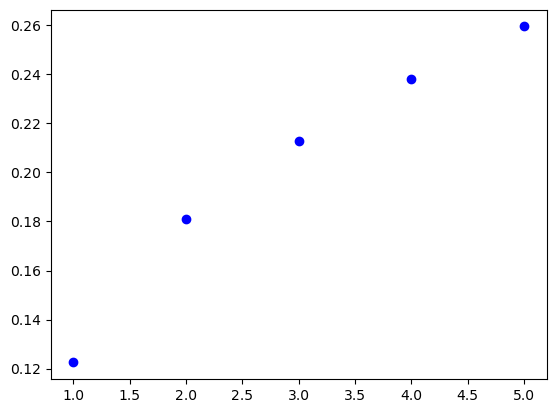

In [63]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc_history) + 1)
plt.plot(epochs, train_acc_history, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_history, 'rx', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()
plt.show()

NameError: name 'val_loss_history' is not defined

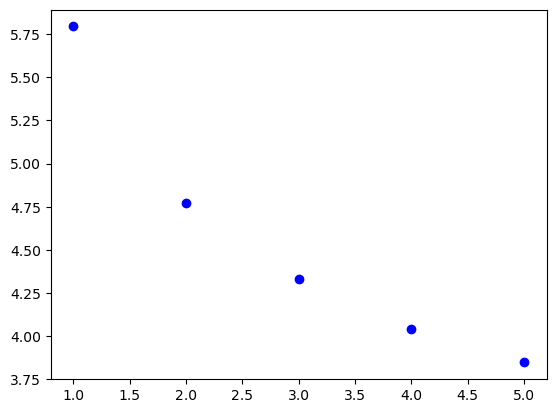

In [64]:
epochs = range(1, len(train_loss_history) + 1)
plt.plot(epochs, train_loss_history, 'bo', label='Training loss')
plt.plot(epochs, val_loss_history, 'rx', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()
plt.show()

In [65]:
# torch.save(model, 'cbow_dickens')

In [66]:
model[0].weight

Parameter containing:
tensor([[ 0.3609,  0.3096, -0.2217,  ...,  1.2700, -0.4037, -0.5127],
        [-0.1245, -3.1342, -1.5394,  ...,  2.0359,  0.6421,  0.4744],
        [ 0.2404,  2.2039, -1.3967,  ...,  0.9678,  4.0001,  0.4083],
        ...,
        [-0.2823,  1.6095, -0.0814,  ..., -0.9071,  0.5590,  0.0990],
        [ 0.4916,  0.7561,  0.3830,  ...,  2.1038, -0.4286,  0.9438],
        [ 0.2610,  1.7445,  0.8745,  ..., -0.7903, -1.0701,  0.2558]],
       requires_grad=True)

In [67]:
model.state_dict()['0.weight']

tensor([[ 0.3609,  0.3096, -0.2217,  ...,  1.2700, -0.4037, -0.5127],
        [-0.1245, -3.1342, -1.5394,  ...,  2.0359,  0.6421,  0.4744],
        [ 0.2404,  2.2039, -1.3967,  ...,  0.9678,  4.0001,  0.4083],
        ...,
        [-0.2823,  1.6095, -0.0814,  ..., -0.9071,  0.5590,  0.0990],
        [ 0.4916,  0.7561,  0.3830,  ...,  2.1038, -0.4286,  0.9438],
        [ 0.2610,  1.7445,  0.8745,  ..., -0.7903, -1.0701,  0.2558]])

In [68]:
model[0].weight.size()

torch.Size([9768, 50])

In [69]:
import pandas as pd

df = pd.DataFrame(
    model[0].weight.detach().numpy(), 
    index=[idx2word[i] for i in range(len(idx2word))])

In [70]:
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
a,0.360905,0.309618,-0.221730,0.102910,1.233467,-0.619417,0.354415,-0.909990,1.558370,-1.557356,...,-1.415021,0.931507,0.795877,-0.911840,0.450392,-1.747212,-0.029444,1.269959,-0.403748,-0.512697
abantes,-0.124511,-3.134156,-1.539351,-2.213443,-0.528597,0.878430,2.515538,1.315774,0.684114,0.416358,...,-2.626820,-0.523154,1.468027,-0.373985,-2.501289,-2.501449,-0.455023,2.035898,0.642090,0.474413
abarbarea,0.240392,2.203930,-1.396699,2.816573,-1.141785,-0.395663,0.210799,-0.032763,2.466990,0.214982,...,-0.293705,-0.132710,0.230625,0.253468,-0.001569,-0.746037,-1.209782,0.967773,4.000123,0.408297
abas,-0.249593,-0.809223,1.430726,0.508630,-2.297618,-4.433473,0.266501,0.375968,0.536330,-1.024946,...,-0.402080,0.275511,1.027664,0.480708,0.152093,1.406158,0.244994,0.317736,-0.834975,-1.185916
abate,-1.768644,0.180203,-2.018601,0.111741,-1.087932,-0.070355,-0.942351,0.241398,0.823600,-1.108382,...,2.055421,-1.964629,1.020981,-2.229958,0.945172,-3.684698,1.405313,-0.119008,2.511402,-0.371257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zeal,2.149769,0.298278,-2.283236,-3.378420,-0.715643,-2.243176,-1.766015,-0.477300,-1.198361,-0.898667,...,1.032845,1.353052,-1.097090,-1.024076,1.476706,0.014351,0.686022,2.088631,1.900561,-1.801711
zelea,-1.139118,0.382446,1.378164,0.510787,-0.739776,0.012274,0.704571,0.661585,2.927667,-2.147072,...,0.490746,0.946405,1.114837,-1.756375,2.087635,-1.895787,-0.636752,1.367887,0.891487,3.895625
zephyrus,-0.282296,1.609492,-0.081373,2.036999,0.416994,-0.089048,1.369559,-0.564614,-0.549927,-0.140541,...,0.589239,1.434375,1.906418,0.617077,-2.534457,-1.210817,1.392520,-0.907114,0.559045,0.098993
zethus,0.491612,0.756094,0.382969,-0.307649,-3.048690,-1.725932,2.698186,0.808782,0.673495,1.091117,...,0.600674,1.648937,1.133444,0.776669,0.174629,-2.442813,0.469771,2.103827,-0.428551,0.943839


In [71]:
# CBOW_GEN_VECTOR_FILE = 'cbow_pt_dickent.txt'
# df.to_csv(CBOW_GEN_VECTOR_FILE, sep=' ', header=False)

## Similarity

In [72]:
sim_test_words(test_words, word2idx, model, N=3)

he ['she', 'achilles', 'they']
she ['he', 'they', 'i']
ulysses ['telemachus', 'circe', 'menelaus']
penelope ['circe', 'chirrup', 'ulysses']
achaeans ['danaans', 'trojans', 'argives']
trojans ['danaans', 'achaeans', 'argives']
achilles ['hector', 'agamemnon', 'idomeneus']
sea ['seas', 'bottom', 'daybreak']
helen ['barking', 'laodamas', 'pisander']
ship ['tools', 'tent', 'nape']
her ['your', 'his', 'blithe']
fight ['remain', 'bathe', 'rout']


In [ ]:
"""
NAdam 0.025 64
he ['she', 'they', 'i', 'alegenor', 'we', 'shoo', 'achilles', 'antilochus', 'xaging', 'it']
she ['he', 'they', 'nausicaa', 'i', 'we', 'juno', 'oeneus', 'raven', 'alcestis', 'minerva']
ulysses ['telemachus', 'alexandrus', 'melanthius', 'peleus', 'antinous', 'diomed', 'eumaeus', 'angrily', 'rag', 'belonged']
penelope ['telemachus', 'juno', 'nausicaa', 'arete', 'melaneus', 'noemon', 'cisseus', 'jove', 'august', 'arybas']
achaeans ['danaans', 'argives', 'trojans', 'crowning', 'suitors', 'bench', 'lycians', 'ephyri', 'precincts', 'gods']
trojans ['danaans', 'achaeans', 'argives', 'suitors', 'others', 'packing', 'centaurs', 'rout', 'cephallenians', 'ies']
"""

In [ ]:
"""
NAdam 0.025 32
he ['she', 'achilles', 'they', 'i', 'ulysses', 'we', 'minerva', 'alision', 'papa', 'euryalus']
she ['he', 'they', 'i', 'euryalus', 'we', 'juno', 'ulysses', 'euryclea', 'nausicaa', 'minerva']
ulysses ['telemachus', 'achilles', 'agamemnon', 'antinous', 'nestor', 'juno', 'menelaus', 'neptune', 'alcinous', 'dreamland']
penelope ['juno', 'telemachus', 'ulysses', 'numberless', 'dress', 'eilesium', 'alcinous', 'pisistratus', 'apollo', 'prayer']
achaeans ['danaans', 'argives', 'trojans', 'others', 'suitors', 'gods', 'myrmidons', 'chiefest', 'rest', 'locrians']
trojans ['achaeans', 'argives', 'danaans', 'maker', 'myrmidons', 'pylaeus', 'ephyri', 'mainland', 'lycians', 'suitors']
"""

In [ ]:
"""
NAdam 0.025
he ['she', 'they', 'i', 'teucer', 'we', 'epeigeus', 'overturned', 'arnaeus', 'stoutly', 'alision']
she ['he', 'they', 'happening', 'diana', 'heartily', 'shrouds', 'ulysses', 'augury', 'earnings', 'circe']
ulysses ['telemachus', 'achilles', 'agamemnon', 'peleus', 'bark', 'euryalus', 'euaemon', 'retreat', 'melantho', 'melanthius']
penelope ['telemachus', 'thersites', 'content', 'heedless', 'farewell', 'august', 'eumaeus', 'arne', 'trifles', 'juno']
achaeans ['argives', 'juice', 'chalk', 'mainstays', 'lycians', 'trojans', 'pervaded', 'danaans', 'islands', 'lelegae']
trojans ['argives', 'seashore', 'crowning', 'danaans', 'curetes', 'achaeans', 'tip', 'unflinching', 'darts', 'ajaxes']
"""

In [ ]:
"""
he ['she', 'they', 'i', 'we', 'pillows', 'achilles', 'chiron', 'cases', 'vassal', 'thrives']
she ['he', 'they', 'papa', 'i', 'dardanus', 'we', 'shrouds', 'penelope', 'pillows', 'vassal']
ulysses ['antinous', 'diomed', 'menelaus', 'peleus', 'telemachus', 'hector', 'amphiclus', 'sisyphus', 'schedius', 'meriones']
penelope ['telemachus', 'venus', 'reflected', 'ointment', 'aspen', 'ivory', 'autolycus', 'nereus', 'jove', 'wheelwright']
achaeans ['danaans', 'phoceans', 'games', 'argives', 'phalanxes', 'heralds', 'mainstays', 'clattering', 'fulness', 'trojans']
trojans ['danaans', 'thracians', 'ringleaders', 'achaeans', 'argives', 'cythereans', 'tendons', 'strangers', 'platform', 'stepmother']"""

In [ ]:
# CBOW_GEN_VECTOR_FILE = 'cbow_pt_dickent.txt'
# df.to_csv(CBOW_GEN_VECTOR_FILE, sep=' ', header=False)

In [ ]:
"""
RMS 10 0.1 1024
he ['she', 'they', 'i', 'nicholas', 'it', 'bullyers', 'reducible', 'we', 'oliver', 'superstitiously']
she ['he', 'they', 'i', 'florence', 'superstitiously', 'nicholas', 'it', 'topographical', 'we', 'bullyers']
paris ['london', 'switzerland', 'newgate', 'default', 'aeronautics', 'italy', 'yorkshire', 'earwigs', 'town', 'rome']
london ['paris', 'india', 'england', 'town', 'harley', 'chertsey', 'highgate', 'ipswich', 'greta', 'blackfriars']
table ['desk', 'chimneypiece', 'sideboard', 'room', 'floor', 'tables', 'sofa', 'stove', 'beach', 'settee']
rare ['defective', 'gratuitous', 'capital', 'perversion', 'curator', 'chatty', 'hymn', 'common', 'dense', 'funny']
monday ['thursday', 'friday', 'sunday', 'wednesday', 'accounts', 'verged', 'occasions', 'heaths', 'studies', 'morrow']
sunday ['wednesday', 'friday', 'saturday', 'morning', 'day', 'week', 'monday', 'dialect', 'experimented', 'evenings']
man ['gentleman', 'woman', 'person', 'boy', 'lady', 'creature', 'jew', 'girl', 'child', 'dog']
woman ['man', 'lady', 'girl', 'gentleman', 'child', 'creature', 'boy', 'person', 'jew', 'cherub']
king ['calf', 'devil', 'saracen', 'jambs', 'sortin', 'manufacture', 'clank', 'tribune', 'mob', 'pilot']
queen ['speaker', 'leech', 'hungering', 'shawled', 'needle', 'miracles', 'servants', 'mississes', 'twin', 'straggling']
boy ['girl', 'child', 'creature', 'man', 'jew', 'gentleman', 'woman', 'person', 'sexton', 'dwarf']
girl ['child', 'woman', 'boy', 'creature', 'gentleman', 'lady', 'man', 'widow', 'jew', 'dwarf']"""

In [ ]:
"""
RMS. 0.01, 512, 10
he ['she', 'erylaus', 'we', 'they', 'vassal', 'i', 'thirsting', 'alision', 'aegae', 'syra']
she ['he', 'they', 'joy', 'complexion', 'telemachus', 'pillaged', 'penelope', 'fondly', 'anywhere', 'chalcis']
ulysses ['antinous', 'telemachus', 'euryalus', 'diomed', 'pisistratus', 'capaneus', 'ismarus', 'argue', 'aesculapius', 'axylus']
penelope ['neptune', 'piraeus', 'nisus', 'pisistratus', 'arete', 'circe', 'achilles', 'echeneus', 'such', 'weave']
achaeans ['danaans', 'argives', 'gods', 'others', 'trojans', 'resisted', 'givers', 'habit', 'lycians', 'seashore']
trojans ['danaans', 'thesprotians', 'locrians', 'storming', 'achaeans', 'swineherd', 'rushes', 'issued', 'hazard', 'rangers']"""

In [ ]:
"""
NAdam 0.025 64
he ['she', 'they', 'i', 'it', 'we', 'paul', 'woefully', 'nobody', 'everybody', 'kit']
she ['he', 'they', 'i', 'florence', 'we', 'paul', 'caddy', 'it', 'bella', 'rosa']
paris ['england', 'italy', 'town', 'contravention', 'london', 'columbus', 'switzerland', 'coketown', 'oozy', 'scots']
london ['england', 'saleable', 'town', 'saltatory', 'france', 'paris', 'ina', 'skate', 'reconsidering', 'pestilential']
table ['floor', 'room', 'inkstand', 'fender', 'tables', 'hob', 'spot', 'portico', 'beach', 'pandean']
rare ['stupendous', 'apposite', 'drone', 'simple', 'practical', 'rotatory', 'navigator', 'somnolent', 'rumination', 'cumber']
monday ['sunday', 'noon', 'admissible', 'gunwales', 'wisited', 'brighton', 'farder', 'eulogy', 'forefoot', 'unhindered']
sunday ['monday', 'friday', 'ablutions', 'failure', 'wednesday', 'seeker', 'broomstick', 'forefoot', 'guercino', 'trial']
man ['gentleman', 'woman', 'person', 'lady', 'boy', 'girl', 'creature', 'chap', 'lad', 'surgeon']
woman ['man', 'gentleman', 'creature', 'girl', 'lady', 'child', 'person', 'boy', 'fellow', 'trick']
king ['nests', 'mayor', 'shoemaker', 'heeling', 'originals', 'perfumer', 'darnay', 'cowpock', 'sounders', 'generically']
queen ['gals', 'chancery', 'fellow', 'hanover', 'marine', 'summersets', 'lambs', 'chastity', 'rotund', 'circular']
boy ['child', 'girl', 'man', 'schoolmaster', 'jew', 'woman', 'constable', 'creature', 'gentleman', 'dog']
girl ['child', 'woman', 'creature', 'schoolmaster', 'boy', 'lady', 'man', 'gentleman', 'jew', 'surgeon']
"""

In [ ]:
"""
RMS 1024 0.1 10
he ['she', 'they', 'sheepskin', 'coiranus', 'i', 'heeding', 'papa', 'alesium', 'device', 'keener']
she ['he', 'stars', 'juno', 'emathia', 'nausicaa', 'saffron', 'requital', 'persisted', 'maids', 'unwed']
ulysses ['telemachus', 'nightfall', 'levers', 'piraeus', 'peleus', 'lagging', 'perseus', 'alexandrus', 'achilles', 'melantho']
penelope ['circe', 'antinous', 'nightfall', 'autonoe', 'augurs', 'helen', 'passing', 'dress', 'telemachus', 'precipice']
achaeans ['argives', 'trojans', 'danaans', 'crowning', 'contrary', 'cowards', 'sintians', 'lapithae', 'erymas', 'renewed']
trojans ['achaeans', 'meonians', 'storming', 'argives', 'danaans', 'myrmidons', 'epeans', 'acropolis', 'phrygians', 'tyres']
"""